Added player: Eryndor Thorne
Added location: Royaume de la Lumière
Added player's item: Poignard de chasseur
Added player's item: Potion de soin
Added character: Lady Lirien

Total nodes: 5
Total colors: 5
Nodes: ['Eryndor Thorne', 'Royaume de la Lumière', 'Poignard de chasseur', 'Potion de soin', 'Lady Lirien']


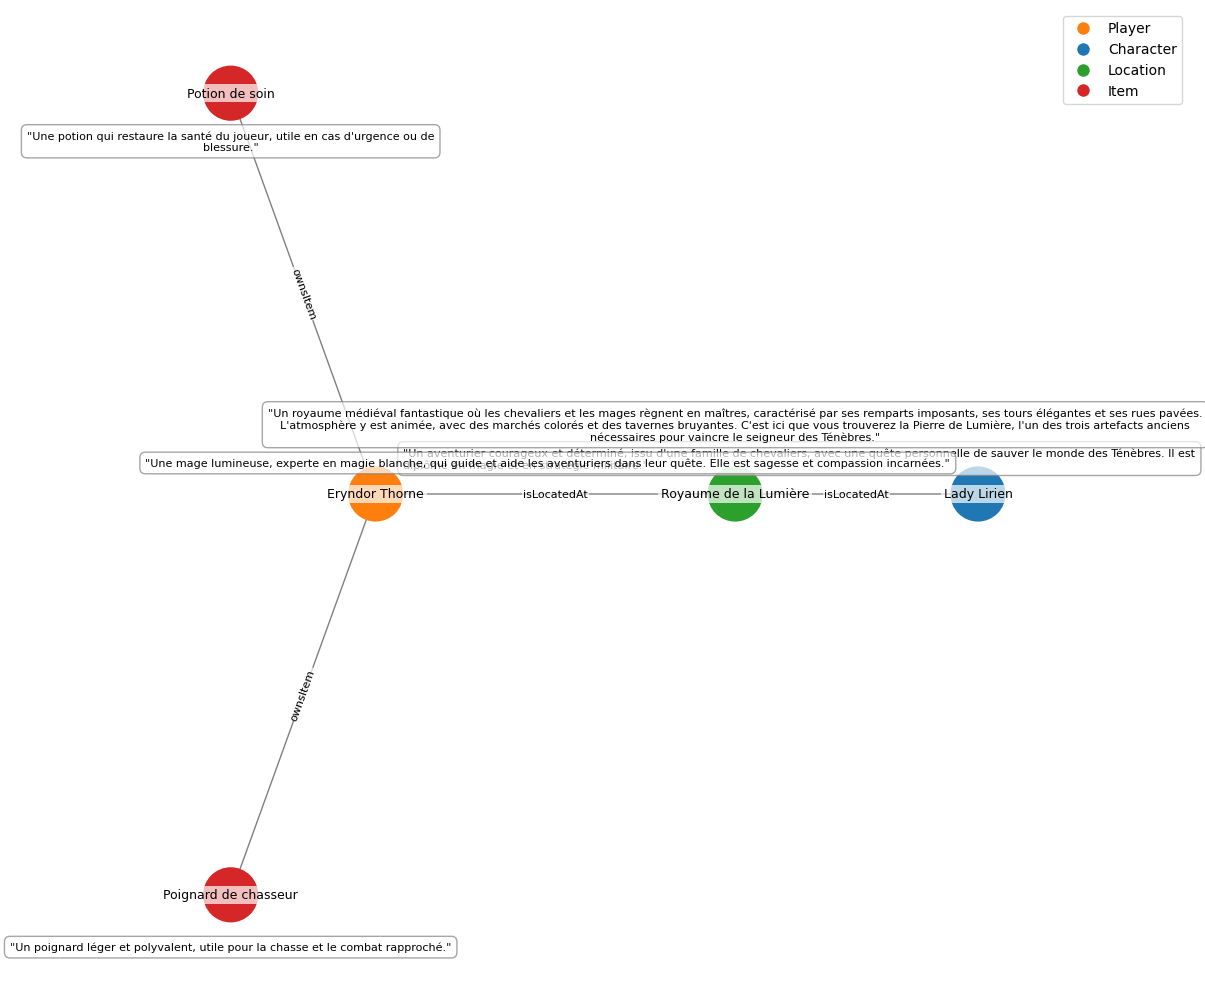

In [61]:
from owlready2 import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def create_story_graph():
    """
    Creates and visualizes a graph of the story world focusing on the player and related entities.

    The graph shows different entity types with distinct colors and their relationships.
    """
    # Load the ontology
    onto = get_ontology("story_poptest70b_fantasy.rdf").load()

    # Create directed graph
    G = nx.DiGraph()

    # Find the player character
    player = onto.search_one(type=onto.Player)

    # Colors for different entity types
    colors = {
        "Player": "#ff7f0e",  # Orange
        "Character": "#1f77b4",  # Blue
        "Location": "#2ca02c",  # Green
        "Item": "#d62728",  # Red
    }

    # Node colors list
    node_colors = []

    # Add player node
    G.add_node(player.hasName)
    node_colors.append(colors["Player"])
    print(f"Added player: {player.hasName}")

    # Add player's location
    player_location = player.characterIsLocatedAt
    G.add_node(player_location.hasName)
    node_colors.append(colors["Location"])
    G.add_edge(player.hasName, player_location.hasName, label="isLocatedAt")
    print(f"Added location: {player_location.hasName}")

    # Add only 2 player's items
    for item in list(player.ownsItem)[:2]:  # Limit to first 2 items
        G.add_node(item.hasName)
        node_colors.append(colors["Item"])
        G.add_edge(player.hasName, item.hasName, label="ownsItem")
        print(f"Added player's item: {item.hasName}")

    # Add only one other character at the same location
    other_chars = [
        char
        for char in onto.Character.instances()
        if char.characterIsLocatedAt == player_location and char != player
    ]
    if other_chars:  # If there are any other characters
        char = other_chars[0]  # Take the first one
        G.add_node(char.hasName)
        node_colors.append(colors["Character"])
        G.add_edge(char.hasName, player_location.hasName, label="isLocatedAt")
        print(f"Added character: {char.hasName}")

    print(f"\nTotal nodes: {len(G.nodes)}")
    print(f"Total colors: {len(node_colors)}")
    print("Nodes:", list(G.nodes))

    # Create the visualization
    plt.figure(figsize=(12, 10))

    # pos = nx.spring_layout(G, k=0.25, iterations=15)
    pos = nx.spectral_layout(G)
    # Adjust positions to make room for descriptions
    pos = {node: (coord[0] * 1.5, coord[1] * 1.5) for node, coord in pos.items()}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)

    # Draw edges and basic labels as before
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=15)
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=2),
    )

    # Add descriptions as annotations with different offsets for each node type
    offsets = {
        "Player": (20, 20),  # right, up
        "Character": (-20, 20),  # left, up
        "Location": (0, 40),  # center, up
        "Item": (0, -40),  # center, down
    }

    for node in G.nodes():
        entity = None
        entity_type = None

        # Determine entity and its type
        if node == player.hasName:
            entity = player
            entity_type = "Player"
        else:
            for type_name, instances in [
                ("Character", onto.Character.instances()),
                ("Item", onto.Item.instances()),
                ("Location", onto.Location.instances()),
            ]:
                for instance in instances:
                    if instance.hasName == node:
                        entity = instance
                        entity_type = type_name
                        break
                if entity:
                    break

        if entity and hasattr(entity, "hasDescription"):
            desc = entity.hasDescription
            # Get offset based on entity type
            offset = offsets.get(entity_type, (20, 20))

            plt.annotate(
                f'"{desc}"',
                xy=pos[node],
                xytext=offset,
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.7),
                fontsize=8,
                wrap=True,
                ha="center"
                if offset[0] == 0
                else ("right" if offset[0] < 0 else "left"),
            )

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels,
        font_size=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
    )

    # Add legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color,
            label=entity_type,
            markersize=10,
        )
        for entity_type, color in colors.items()
    ]
    plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

    plt.axis("off")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    create_story_graph()